In [1]:
!pip install facenet_pytorch
!pip install transformers
!pip install deepface

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 1.9 MB 6.6 MB/s 
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 4.4 MB 2.7 MB/s 
     |████████████████████████████████| 101 kB 13.7 MB/s 
     |████████████████████████████████| 596 kB 59.4 MB/s 
     |████████████████████████████████| 6.6 MB 52.8 MB/s 
  Attempting uninstall: pyyaml
    Found existing installation: PyYAML 3.13
    Uninstalling PyYAML-3.13:
      Successfully uninstalled PyYAML-3.13
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 65 kB 3.0 MB/s 
     |████████████████████████████████| 2.3 MB 13.4 MB/s 
     |████████████████████████████████| 87 kB 9.4 MB/s 
     |████████████████████████████████| 60.9 MB 1.2 MB/s 
  Created wheel for fire: filename=fir

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
import cv2
import torch
import numpy as np
import pandas as pd
from facenet_pytorch import MTCNN
from PIL import Image
from matplotlib import pyplot as plt
from tqdm.notebook import tqdm

from transformers import AutoFeatureExtractor, AutoModelForImageClassification

from deepface import DeepFace

Directory  /root /.deepface created
Directory  /root /.deepface/weights created


In [4]:
'cuda' if torch.cuda.is_available() else 'cpu'

'cpu'

In [5]:
# video_path =  '/content/drive/MyDrive/05_pytorch/HACKATON_emotions/titanic.mp4'
# video_path = 'https://youtu.be/1pLuJVmdehg'
video_path = '/content/drive/MyDrive/05_pytorch/HACKATON_emotions/project.mp4'
# video_path = '/content/drive/MyDrive/05_pytorch/HACKATON_emotions/sad.mp4'

In [6]:
v_cap = cv2.VideoCapture(video_path)
v_len = int(v_cap.get(cv2.CAP_PROP_FRAME_COUNT))


class FaceDetector(object):
    """
    Face detector class
    """
      
    def __init__(self, mtcnn):
        self.mtcnn = mtcnn
        self.device = 'cuda' if torch.cuda.is_available() else 'cpu'
        self.extractor = AutoFeatureExtractor.from_pretrained("Rajaram1996/FacialEmoRecog")
        self.emotion_model = AutoModelForImageClassification.from_pretrained("Rajaram1996/FacialEmoRecog")
        self.emotion_model.eval()
        self.soft_max = torch.nn.Softmax(dim=0)
        self.faces = []
        self.face_image_limit = 70
        self.frames = []


    def predict_emotion(self, image_num):

        inputs = self.extractor(self.faces[image_num], return_tensors="pt")

        with torch.no_grad():
            logits = self.emotion_model(**inputs).logits

        variances = self.soft_max(logits[0])

        # model predicts one of the 1000 ImageNet classes
        predicted_label = variances.argmax(-1).item()
        
        print(plt.imshow(self.faces[image_num]))
        print(f'\nResult {self.emotion_model.config.id2label[predicted_label]} {variances[predicted_label]*100:.4}%')

        for i in range(len(variances)):
            print(f'{self.emotion_model.config.id2label[i]} {variances[i]*100:.4}%')


    def run(self):
        batch_size = 16

        for frame_num in tqdm(range(v_len)):
        # for frame_num in tqdm(range(800)):

            if frame_num % 6 == 0:
                # Load frame
                success, frame = v_cap.read()
                if not success:
                    continue
                    
                # Add to batch
                frame = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)
                frame = Image.fromarray(frame)
                self.frames.append(frame)
                
                # When batch is full, detect faces and reset batch list
                if len(self.frames) >= batch_size:
                    
                    try:
                        batch_boxes, _, batch_landmarks = self.mtcnn.detect(self.frames, landmarks=True)

                        for boxes, landmarks, frame in zip(batch_boxes, batch_landmarks, self.frames):
                            
                            # several faces in one frame
                            for box, landmark in zip(boxes, landmarks):
                                face_image = frame.crop((int(box[0]), int(box[1]), int(box[2]), int(box[3])))

                                # take faces more than <face_image_limit> pixels in one of the dims
                                if face_image.size[0] > self.face_image_limit and face_image.size[1] > self.face_image_limit:
                                    self.faces.append(face_image)
                        
                    except:
                        pass

        v_cap.release()
        cv2.destroyAllWindows()

      

In [7]:
%%time
# Run the app
mtcnn = MTCNN()
fcd = FaceDetector(mtcnn)
fcd.run()

Downloading:   0%|          | 0.00/228 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/881 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/327M [00:00<?, ?B/s]

  0%|          | 0/194 [00:00<?, ?it/s]

CPU times: user 4min 8s, sys: 6.53 s, total: 4min 15s
Wall time: 4min 21s


In [8]:
v_len

194

In [9]:
# fcd.predict_emotion(42)

In [10]:
# foto1 = '/content/drive/MyDrive/05_pytorch/HACKATON_emotions/leo1.jpg'
# foto2 = '/content/drive/MyDrive/05_pytorch/HACKATON_emotions/leo2.jpg'
# foto3 = '/content/drive/MyDrive/05_pytorch/HACKATON_emotions/leo3.jpg'
# super = '/content/drive/MyDrive/05_pytorch/HACKATON_emotions/super.jpg'
# people = '/content/drive/MyDrive/05_pytorch/HACKATON_emotions/people.jpg'

In [11]:
# DeepFace.verify(img1_path = foto1, img2_path = foto2)

In [12]:
# DeepFace.verify(img1_path = foto1, img2_path = foto3, enforce_detection=False)

In [13]:
# DeepFace.verify(img1_path = foto2, img2_path = super)

In [14]:
# DeepFace.analyze(img_path = foto1, actions = ['age', 'emotion'])

In [15]:
len(fcd.faces)

486

In [16]:
DeepFace.analyze(img_path = np.array(fcd.faces[20]), actions = ['age', 'emotion'], enforce_detection=False)

facial_expression_model_weights.h5 will be downloaded...


Downloading...
From: https://github.com/serengil/deepface_models/releases/download/v1.0/facial_expression_model_weights.h5
To: /root/.deepface/weights/facial_expression_model_weights.h5
100%|██████████| 5.98M/5.98M [00:00<00:00, 9.75MB/s]


age_model_weights.h5 will be downloaded...


Downloading...
From: https://github.com/serengil/deepface_models/releases/download/v1.0/age_model_weights.h5
To: /root/.deepface/weights/age_model_weights.h5
100%|██████████| 539M/539M [00:19<00:00, 27.0MB/s]
Action: emotion: 100%|██████████| 2/2 [00:01<00:00,  1.62it/s]


{'age': 26,
 'dominant_emotion': 'sad',
 'emotion': {'angry': 25.62457177785467,
  'disgust': 1.7279802920210536,
  'fear': 6.064151961454866,
  'happy': 8.94149148115465,
  'neutral': 21.10796845602801,
  'sad': 33.31516583652293,
  'surprise': 3.2186700086992985},
 'region': {'h': 110, 'w': 138, 'x': 0, 'y': 0}}

AxesImage(54,36;334.8x217.44)

Result disgust 16.61%
anger 13.48%
contempt 16.41%
disgust 16.61%
fear 6.333%
happy 16.38%
neutral 14.39%
sadness 8.159%
surprise 8.236%


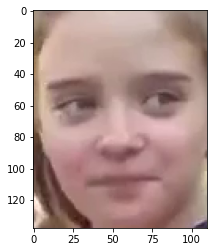

In [17]:
fcd.predict_emotion(20)

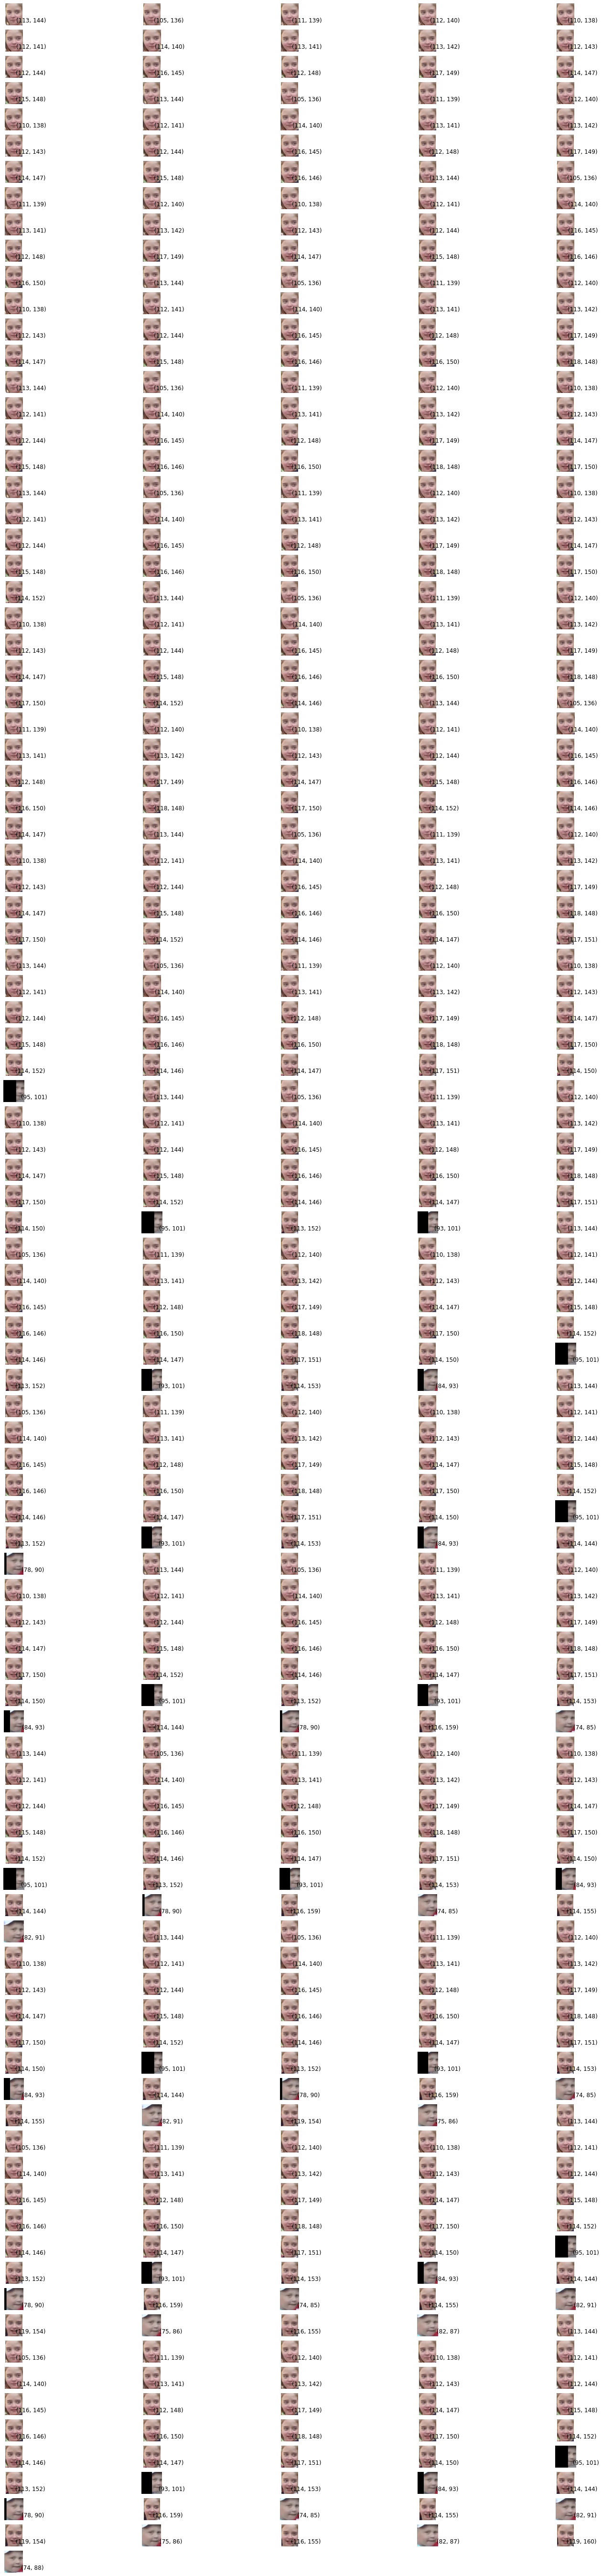

In [19]:
pic_box = plt.figure(figsize=(25,100))

for i, picture in enumerate(fcd.faces):
    pic_box.add_subplot(len(fcd.faces)//5+2,5,i+1)
    plt.imshow(picture)
    plt.title(picture.size, x=1.5, y=0)

    plt.axis('off')

plt.show()

In [20]:
import pandas as pd

In [21]:
# fcd.emotion_model.config

In [22]:
df = pd.DataFrame(columns=['photo', 'frame_num', 'person_id', 'anger', 'contempt', 'disgust', 'fear', 'happy', 'neutral', 'sadness', 'surprise'])

In [ ]:
new_record = {'photo': np.array(fcd.faces[0]),
              'frame_num': 50,
              'person_id': 0,
              'anger':30.5,
              'contempt':40.5,
              'disgust':50.5,
              'fear':42.2,
              'happy':56.5,
              'neutral':57.3,
              'sadness':6.5,
              'surprise':48.9,
              }

df = df.append(new_record, ignore_index=True)

In [196]:
person_list = []
compare_model = 'ArcFace'

for img in fcd.faces[:10]:
    # emotion = DeepFace.analyze(img_path = np.array(img), actions = ['age', 'emotion'], enforce_detection=False)['dominant_emotion']
    new_record = {'photo': np.array(img),
                  'frame_num': 50,
                  # 'person_id': 0,
                  'anger':30.5,
                  'contempt':40.5,
                  'disgust':50.5,
                  'fear':42.2,
                  'happy':56.5,
                  'neutral':57.3,
                  'sadness':6.5,
                  'surprise':48.9,
                  }
    
    if person_list:
        # if not empty person_list
        added_person = 0
        for exist_person in person_list:
            # сравниваем img с людьми в person_list (true если одинаковый)
            if DeepFace.verify(img1_path = np.array(exist_person), img2_path = np.array(img), enforce_detection=False, model_name=compare_model)['verified']:
                # значит уже есть в базе - заносим img как уже существующего
                new_record = {'person_id': 0,
                              }
                break
            else:
                added_person += 1
        if added_person == len(person_list):
            # add another person into DB
            person_list.append(img)
            new_record = {'person_id': 0,
              }
            print(len(person_list))
            # значит еще в базе - заносим img как нового
            pass

    else:
        # add first if no persons
        person_list.append(img)
        # заносим в БД первого
        print(len(person_list))

1
2
3


In [197]:
person_list

[<PIL.Image.Image image mode=RGB size=113x144 at 0x7F6706F52990>,
 <PIL.Image.Image image mode=RGB size=95x101 at 0x7F6706E6BA50>,
 <PIL.Image.Image image mode=RGB size=75x86 at 0x7F6706ED0090>]

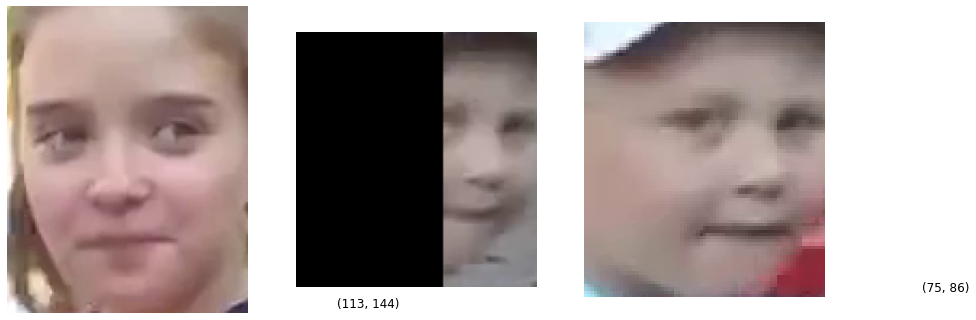

In [198]:
pic_box = plt.figure(figsize=(25,100))

for i, picture in enumerate(person_list):
    pic_box.add_subplot(len(person_list)//5+2,5,i+1)
    plt.imshow(picture)
    plt.title(picture.size, x=1.5, y=0)

    plt.axis('off')

plt.show()

In [23]:
# plt.imshow(Image.open(foto1))